## Setting

In [1]:
# !pip install ipywidgets plotly geopandas tilemapbase shapely

In [2]:
#ライブラリの読み込み
import requests
import shutil
import codecs
import math as mt
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
import geopandas as gpd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'
import matplotlib.pyplot as plt
import tilemapbase
tilemapbase.init(create=True)
from shapely import geometry
import warnings
warnings.simplefilter('ignore')

In [3]:
# 緯度経度からメッシュコードを生成する関数
class latlon2grid:
    def grid1st(lon, lat):  # 1次メッシュ(4桁) 分割なし
        return int(mt.floor(lat*1.5)) * 100 + int(mt.floor(lon-100))

    def grid2nd(lon, lat):  # 2次メッシュ(6桁) 8分割
       return (int(mt.floor(lat*12       / 8))   * 10000 + int(mt.floor((lon-100)*8         / 8))  * 100   +   
               int(mt.floor(lat*12 %  8     ))   * 10    + int(mt.floor((lon-100)*8))  %  8               )  

    def grid3rd(lon, lat):  # 3次メッシュ(8桁) 8分割x10分割=80分割
        return (int(mt.floor(lat*120      / 80)) * 1000000 + int(mt.floor((lon-100))             ) * 10000 +  # 1次メッシュ
                int(mt.floor(lat*120 % 80 / 10)) * 1000    + int(mt.floor((lon-100)*80 % 80 / 10)) * 100 +    # 2次メッシュ
                int(mt.floor(lat*120 % 10))      * 10      + int(mt.floor((lon-100)*80)) % 10               ) 

    def grid4th(lon, lat):  # 4次メッシュ(9桁) 8分割x10分割x2分割=160分割
        return (int(mt.floor(lat*240       / 160)) * 10000000 + int(mt.floor((lon-100)*160       / 160)) * 100000 +    # 1次メッシュ
                int(mt.floor(lat*240 % 160 / 20))  * 10000    + int(mt.floor((lon-100)*160 % 160 / 20))  * 1000   +    # 2次メッシュ
                int(mt.floor(lat*240 % 20  / 2))   * 100      + int(mt.floor((lon-100)*160 % 20  / 2))   * 10     +    # 3次メッシュ
                int(mt.floor(lat*240)) % 2         * 2        + int(mt.floor((lon-100)*160)) % 2                  + 1) # 4次メッシュ

In [4]:
# e-statsのメッシュポリゴンを整形する関数
def aggregate_mesh(x, level):
    tmp = x.copy()
    code_len = [4, 6, 8, 9, 10][level-1]
    tmp["key"] = tmp["KEY_CODE"].str.slice(0, code_len)
    tmp = tmp[["key", "geometry"]]
    tmp = tmp.dissolve(by="key")
    return tmp

In [5]:
# メッシュ上に文字列を表示する関数
def plot_on_map_with_text(geoseries, texts):
    # find the graph range
    rect = geoseries.total_bounds
    edgex = rect[2] - rect[0]
    edgey = rect[3] - rect[1]
    extent = tilemapbase.Extent.from_lonlat(
        rect[0]-edgex*0.3, rect[2]+edgex*0.3,
        rect[1]-edgey*0.3, rect[3]+edgey*0.3)
    extent = extent.to_aspect(1.0)

    fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    t = tilemapbase.tiles.build_OSM()
    plotter = tilemapbase.Plotter(extent, t, width=600)
    plotter.plot(ax, t)

    polygons = []
    centers = []
    bounds = geoseries.bounds
    for i in range(len(bounds)):
        # convert to the plottable scale
        minx, miny = tilemapbase.project(bounds['minx'][i], bounds['miny'][i])
        maxx, maxy = tilemapbase.project(bounds['maxx'][i], bounds['maxy'][i])
        polygons.append(
            geometry.box(minx, miny, maxx, maxy))
        centers.append([(minx + maxx)/2.0, (miny + maxy)/2.0])

    polygons = gpd.GeoSeries(polygons)
    gpd.plotting.plot_polygon_collection(ax, polygons,
                            edgecolor='#121212', facecolor='#000000', alpha=0.4)
    for center, txt in zip(centers, texts):
        ax.text(center[0], center[1], txt, fontdict={'color':'lightblue', 'size':18})
    return fig, ax

## Preprocessing

In [6]:
#ファイル読み込み
with codecs.open('./sample.csv', 'rb', 'SHIFT_JIS','ignore') as f:
    df = pd.read_csv(f)
print(df.shape)
df.head(1)

(242, 16)


,デバイスUID,GPS時刻,緯度,経度,向き,速度,高度,エンジン回転数,アクセル踏み込み,燃料使用量,燃料レベル,主電源電圧,エンジン冷却温度,エンジン負荷,エンジン警告灯,累積走行距離
0,atrack-358683062461653,2016-10-03T06:44:29,35.675186,139.774118,60,0,6,0,17,0.8,10.3,14.4,74,0,False,13.4


In [7]:
# 4次メッシュコード付与
df['4th_mesh_code'] = df.apply(lambda row:latlon2grid.grid4th(row['経度'], row['緯度']), axis=1)
print(df.shape)
df.head(1)

(242, 17)


,デバイスUID,GPS時刻,緯度,経度,向き,速度,高度,エンジン回転数,アクセル踏み込み,燃料使用量,燃料レベル,主電源電圧,エンジン冷却温度,エンジン負荷,エンジン警告灯,累積走行距離,4th_mesh_code
0,atrack-358683062461653,2016-10-03T06:44:29,35.675186,139.774118,60,0,6,0,17,0.8,10.3,14.4,74,0,False,13.4,533946112


In [8]:
# e-statsのメッシュデータをダウンロード・解凍
url='https://www.e-stat.go.jp/gis/statmap-search/data?dlserveyId=Q&code=5339&coordSys=1&format=shape&downloadType=5'
filename='QDDSWQ5339.zip'
urlData = requests.get(url).content
with open(filename ,mode='wb') as f:
  f.write(urlData)
shutil.unpack_archive('QDDSWQ5339.zip', 'QDDSWQ5339')

x = gpd.read_file("QDDSWQ5339/MESH05339.shp")
print(x.shape)
x.head(1)

(100800, 8)


,KEY_CODE,MESH1_ID,MESH2_ID,MESH3_ID,MESH4_ID,MESH5_ID,OBJ_ID,geometry
0,5339000011,5339,00,00,1,1,1,"POLYGON ((139.00312 35.33333, 139.00000 35.333..."


## trajectories(経路の可視化)

In [18]:
fig = px.scatter_mapbox(
    df,
    lat="緯度",
    lon="経度",
    zoom = 14,
    center={"lat": 35.66585, "lon": 139.787},
    opacity=0.5,
    width=800,
    height=800,
    mapbox_style="carto-positron",
)
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(title_text="GPS trajectories")
fig.show()

## stats(メッシュ毎のレコード数カウント)

In [10]:
# 集計対象データの加工
df['4th_mesh_code'] = df['4th_mesh_code'].apply(lambda x: str(x)) #メッシュコードを突合するために文字列に型変換
df['count'] =1 #集計用のカラムを追加

In [11]:
# メッシュデータの加工(4次メッシュコード付与)
x['4th_mesh_code'] = x['MESH1_ID'] + x['MESH2_ID'] + x['MESH3_ID'] + x['MESH4_ID']

In [12]:
# 集計対象のメッシュに絞り込み
mesh = aggregate_mesh(x[x['4th_mesh_code'].isin(df['4th_mesh_code'].to_list())],4)

In [13]:
# 可視化用データ整形
mesh.sort_values('key',inplace=True) #メッシュコード昇順に並べ替え
agg = df.groupby('4th_mesh_code').sum().reset_index()[['4th_mesh_code','count']].sort_values('4th_mesh_code') #メッシュコード毎のレコード件数をカウント＆メッシュコード昇順に並べ替え

(<Figure size 800x800 with 1 Axes>, <Axes: >)

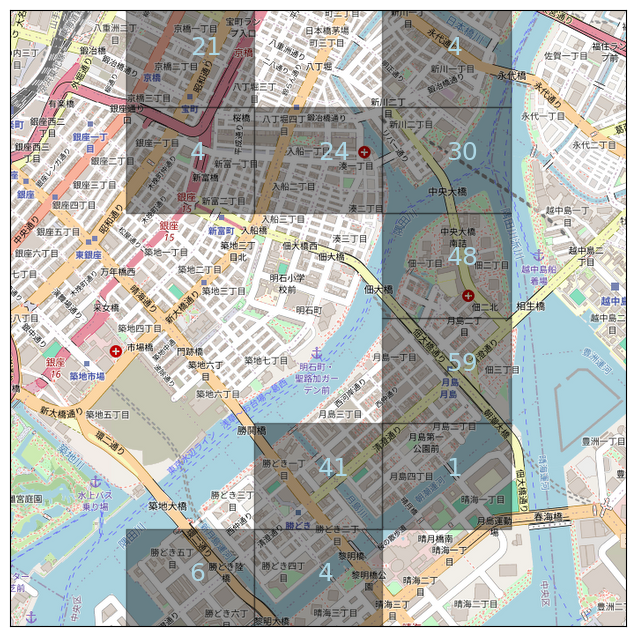

In [14]:
# 描画
plot_on_map_with_text(mesh, agg['count'])

### -EOF